#### 필요한 데이터와 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [2]:
train = pd.read_csv('c:/data/titanic/train.csv')
test = pd.read_csv('c:/data/titanic/test.csv')
IDtest = test['PassengerId']

#### 이상치 탐지 - Tukey method
- IQR = 3분위수 - 1분위수
일 때, (Q1 - 1.5*IQR)보다 작거나, (Q3 + 1.5*IQR) 보다 큰 데이터에 대해서 이상치로 간주한다.

- collections 라이브러리의 Counter메소드는 인자로 받은 리스트의 원소를 키로, 개수를 밸류로 하는 딕셔너리로 반환한다.

In [3]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

Outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
# 탐지한 이상값을 drop한다.
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [6]:
# 범주형 변수 변환시 같은 수치를 얻기 위해서 트레이닝/테스트 데이터를 합쳐준다.
# 합친 데이터를 분리할 때, 미리 설정해놓은 훈련데이터의 수만큼 분할할 수 있도록 훈련데이터의 개수를 저장해놓는다.
train_len = len(train)
dataset = pd.concat(objs=[train,test], axis=0).reset_index(drop=True)

#### 결측치와 널값 체크

In [8]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [10]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [13]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### Feature analysis

#### 수치형 자료
- 먼저 수치형 자료들에 대해서 상관계수를 살펴본다.
- 그 다음으로 변수 하나하나씩 종속변수와 함께 살펴본다.

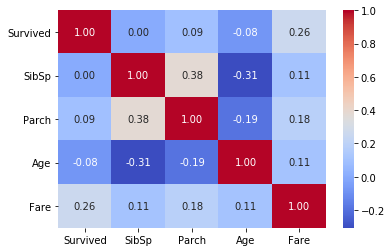

In [14]:
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(), annot=True, fmt = '.2f', cmap='coolwarm')

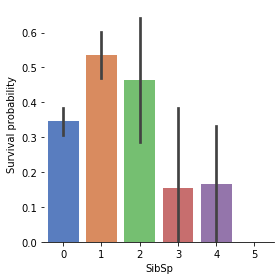

In [23]:
# SibSp
g = sns.catplot(x = 'SibSp', y='Survived',data=train,kind='bar', height=4, palette = 'muted')

g.despine(left=True)
g = g.set_ylabels('Survival probability')

- SibSp의 수가 많을수록 생존률이 떨어지는 듯 보인다.
- 0~2의 수를 가질 때 생존률이 높다.

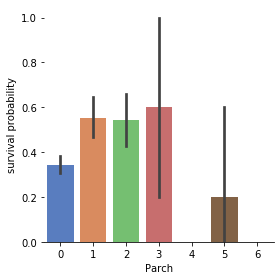

In [25]:
#Parch
g = sns.catplot(x = 'Parch', y= 'Survived', data =train, kind='bar', height= 4, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 가족의 수가 적을수록 생존률이 높은 경향이 있다.
- 수치 3에 표준편차가 크다.

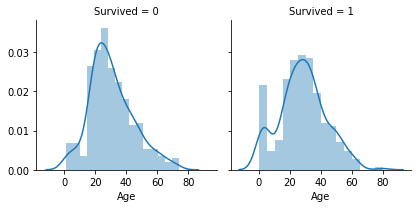

In [27]:
# Age
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, 'Age')

- 나이 분포는 생존의 클래스마다 다른 양상을 보인다. 60-80세의 경우, 생존률이 낮았고 어린 승객의 경우 생존률이 높았음을 확인할 수 있다.

- 위 상관계수 히트맵에서 나이가 생존과 관련이 크게 없었다고 해도(-0.08) 특정 나이 범주에서 생존을 더/덜한 케이스를 위의 분포로 확인할 수 있다.

- 매우 어린 승객은 생존률이 높았다.

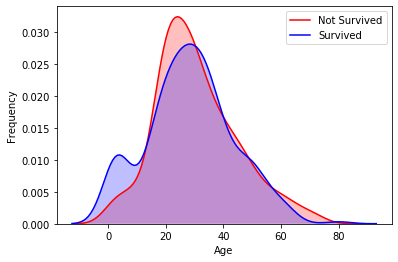

In [33]:
# 나이 분포 살펴보기
# 생존의 두 경우를 결측치가 없는 데이터들을 대상으로 살펴보자.
g = sns.kdeplot(train['Age'][(train['Survived']==0)&(train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1)&(train['Age'].notnull())], color = 'Blue', shade=True)

g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

In [35]:
# Fare
dataset['Fare'].isnull().sum()

1

In [36]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

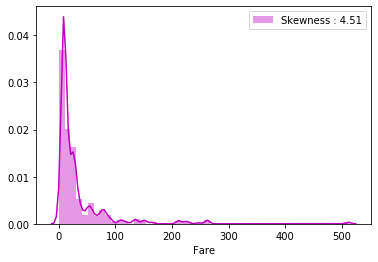

In [40]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%dataset['Fare'].skew())
g = g.legend(loc='best')

fare의 분포는 굉장히 왜도가 높다. 이와같은 경우, 왜도를 줄이기 위해 로그 변환을 해주는 것이 좋다.

In [43]:
dataset['Fare'] = dataset['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

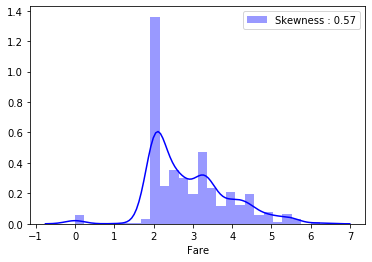

In [52]:
g = sns.distplot(dataset['Fare'], color = 'b', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc='best')

### 범주형 변수 살펴보기

#### Sex

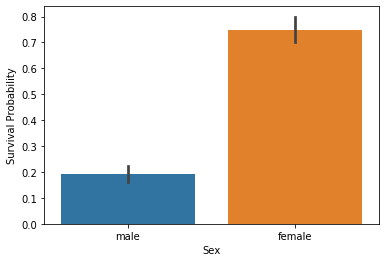

In [55]:
g = sns.barplot(x = 'Sex', y = 'Survived', data = train)
g = g.set_ylabel('Survival Probability')

In [60]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 남성이 여성보다 생존률이 낮은 것이 자명하다.
- Sex 피쳐는 생존 예측에 중요한 변수일 것이다.

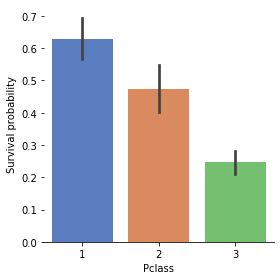

In [64]:
# Pclass
g = sns.catplot(x='Pclass', y='Survived', data = train, kind='bar', height = 4, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

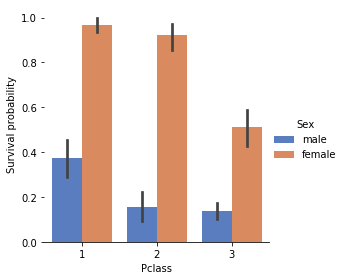

In [66]:
# Sex 별로 살펴보기
g = sns.catplot(x='Pclass', y = 'Survived', hue = 'Sex', data = train, height = 4, kind = 'bar', palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

- 생존률이 클래스 3에서 같지 않다. 클래스가 내려갈수록 생존률이 낮아진다.(남녀 상관 없이)

In [68]:
# Embarked
dataset['Embarked'].isnull().sum()

2

In [69]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

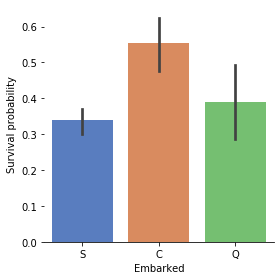

In [70]:
g = sns.catplot(x= 'Embarked', y= 'Survived', data = train, height = 4, kind = 'bar', palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

- C 선착장에서 탄 승객들이 생존률이 더 높게 나타난다.
- C에 탄 사람들이 높은 클래스의 티켓을 가진 승객일 것이라는 가정을 해보자. (C - Q - S 순)

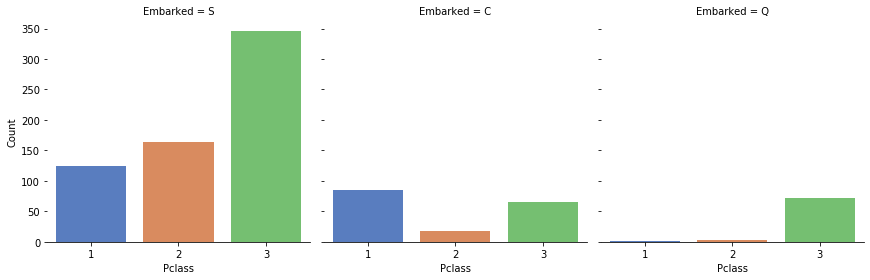

In [71]:
g = sns.catplot('Pclass',col = 'Embarked', data = train, height=4, kind = 'count', palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Count')

- S에 3등석 승객이 굉장히 많은 것을 알 수 있다. 이에반해 C에는 1등석 승객이 상대적으로 많다. Q는 대부분이 3등석이다.(그러나 S에 3등석 승객이 굉장히 많으므로 생존률이 낮은 것 같다.

7/27 결측치 처리 부분부터 다시하기.
https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling